##### 1. Introduction
This notebook focuses on predicting real estate prices in Maricopa County, AZ. We will first use traditional machine learning, followed by a deep learning approach, to understand the nuances and performances of each.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


##### 2. Data Loading, Preprocessing, Exploration


In [70]:
# Load
#--------------------------
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
df = pd.read_csv('data/MaricopaCounty_SampleTransactions_2020_2023.csv')
df = df.dropna(subset=['SOLD DATE'])
df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['SALE_YEAR'] = df['SOLD DATE'].dt.year
df['SALE_MONTH'] = df['SOLD DATE'].dt.month
df['PROPERTY_AGE'] = df['SALE_YEAR'] - df['YEAR BUILT']  # feature engineering: age of the property

#print(df.shape) #51k records 

average_price = df['PRICE'].mean()
median_price = df['PRICE'].median()
print(f"The average house price in the dataset is: ${average_price:.2f}")
print(f"The median house price in the dataset is: ${median_price:.2f}")

# Preprocessing
#--------------------------
drop_columns = ["SALE TYPE", "ADDRESS", "STATE OR PROVINCE", "SOLD DATE", "DAYS ON MARKET", 
                "STATUS", "NEXT OPEN HOUSE START TIME", 
                "NEXT OPEN HOUSE END TIME", 
                "URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)", 
                "SOURCE", "MLS#", "FAVORITE", "INTERESTED", "LOCATION"]
df = df.drop(columns=drop_columns)

# numeric, fill with median 
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)
# categorical, fill with mode 
for col in df.select_dtypes(exclude=['float64', 'int64']).columns:
    mode_value = df[col].mode()
    if not mode_value.empty:
        df[col].fillna(mode_value.iloc[0], inplace=True)

# one-hot encode, easier for ML 
df = pd.get_dummies(df, columns=["PROPERTY TYPE", "CITY", "ZIP OR POSTAL CODE"], drop_first=True)
print("After one-hot encode", df.shape) #After one-hot encode: 51k records 81 columns

# split data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


# Exploration
#--------------------------
# checking skewness for numeric features
skewed_features = train_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
print('Skewed Features (Before Transformation)')
print(skewed_features)

# apply log1p transformation for positively skewed features
positively_skewed = ['HOA/MONTH', 'LOT SIZE', 'BATHS', 'PRICE', 'SQUARE FEET', '$/SQUARE FEET']
for feature in positively_skewed:
    train_df[feature] = np.log1p(train_df[feature])
    val_df[feature] = np.log1p(val_df[feature])
    test_df[feature] = np.log1p(test_df[feature])

# apply cube transformation for negatively skewed features
negatively_skewed = ['LONGITUDE', 'YEAR BUILT']
for feature in negatively_skewed:
    train_df[feature] = train_df[feature]**3
    val_df[feature] = val_df[feature]**3
    test_df[feature] = test_df[feature]**3

# re-check skewness 
new_skewed_features = train_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
print('Skewed Features (After Transformation)')
print(new_skewed_features)

X_train = train_df.drop(columns=["PRICE"])
y_train = train_df["PRICE"]

X_val = val_df.drop(columns=["PRICE"])
y_val = val_df["PRICE"]

X_test = test_df.drop(columns=["PRICE"])
y_test = test_df["PRICE"]

# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

The average house price in the dataset is: $531494.03
The median house price in the dataset is: $419240.00
After one-hot encode (51325, 237)
Skewed Features (Before Transformation)
HOA/MONTH        125.714698
LOT SIZE         112.786633
$/SQUARE FEET    106.060949
BATHS             71.296385
PRICE             10.152511
SQUARE FEET        5.823412
PROPERTY_AGE       0.710824
BEDS               0.634905
LATITUDE          -0.019203
LONGITUDE         -0.518845
YEAR BUILT        -0.706476
dtype: float64
Skewed Features (After Transformation)
BATHS            1.454248
PROPERTY_AGE     0.710824
BEDS             0.634905
$/SQUARE FEET    0.264792
HOA/MONTH        0.075822
LATITUDE        -0.019203
LOT SIZE        -0.235573
SQUARE FEET     -0.352653
LONGITUDE       -0.539292
YEAR BUILT      -0.643960
PRICE           -0.821127
dtype: float64


##### 3. Traditional Machine Learning Implementation (e.g. Ridge Regression)


In [71]:
# linear Regression model
#lr = LinearRegression()
#lr.fit(X_train, y_train)

# Ridge Regression model with cross-validation
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)
print("Best alpha:", ridge_cv.alpha_)

# train the model 
ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(X_train, y_train)

# predict on validation set, convert to original scale, and compute metrics
y_ridge_pred_val = np.expm1(ridge.predict(X_val))
ridge_mae_val = mean_absolute_error(np.expm1(y_val), y_ridge_pred_val)
ridge_mse_val = mean_squared_error(np.expm1(y_val), y_ridge_pred_val)
print(f"Validation MAE for Ridge Regression: ${ridge_mae_val:.2f}")
#print(f"Validation MSE for Ridge Regression: ${ridge_mse_val:.2f}")

# predict on test set, convert to original scale, and compute metrics
y_ridge_pred_test = np.expm1(ridge.predict(X_test))
ridge_mae_test = mean_absolute_error(np.expm1(y_test), y_ridge_pred_test)
ridge_mse_test = mean_squared_error(np.expm1(y_test), y_ridge_pred_test)
print(f"Test MAE for Ridge Regression: ${ridge_mae_test:.2f}")
#print(f"Test MSE for Ridge Regression: ${ridge_mse_test:.2f}")


Best alpha: 0.1
Validation MAE for Ridge Regression: $34607.18
Test MAE for Ridge Regression: $37900.10


##### 4. Neural Network Implementation using Keras & TensorFlow


In [72]:
# design the neural network architecture
nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train the model 
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# predict on validation set, convert to original scale, and compute metrics
y_nn_pred_val = np.expm1(nn_model.predict(X_val).flatten())
nn_mae_val = mean_absolute_error(np.expm1(y_val), y_nn_pred_val)
nn_mse_val = mean_squared_error(np.expm1(y_val), y_nn_pred_val)
print(f"Validation MAE for Neural Network: ${nn_mae_val:.2f}")
##print(f"Validation MSE for Neural Network: ${nn_mse_val:.2f}")

# predict on test set, convert to original scale, and compute metrics
y_nn_pred_test = np.expm1(nn_model.predict(X_test).flatten())
nn_mae_test = mean_absolute_error(np.expm1(y_test), y_nn_pred_test)
nn_mse_test = mean_squared_error(np.expm1(y_test), y_nn_pred_test)
print(f"Test MAE for Neural Network: ${nn_mae_test:.2f}")
#print(f"Test MSE for Neural Network: ${nn_mse_test:.2f}")


# plot Learning curve here perhaps for training and validation 

321/321 [==============================] - 0s 655us/step
Validation MAE for Neural Network: $43002.42
321/321 [==============================] - 0s 648us/step
Test MAE for Neural Network: $43957.03


##### 5. Model Comparison
 

Ridge Regression Metrics:
Test MAE: $37900.10
Neural Network Metrics:
Test MAE: $43957.03
Training time for Ridge Regression: 0.08 seconds
Training time for Neural Network: 53.90 seconds




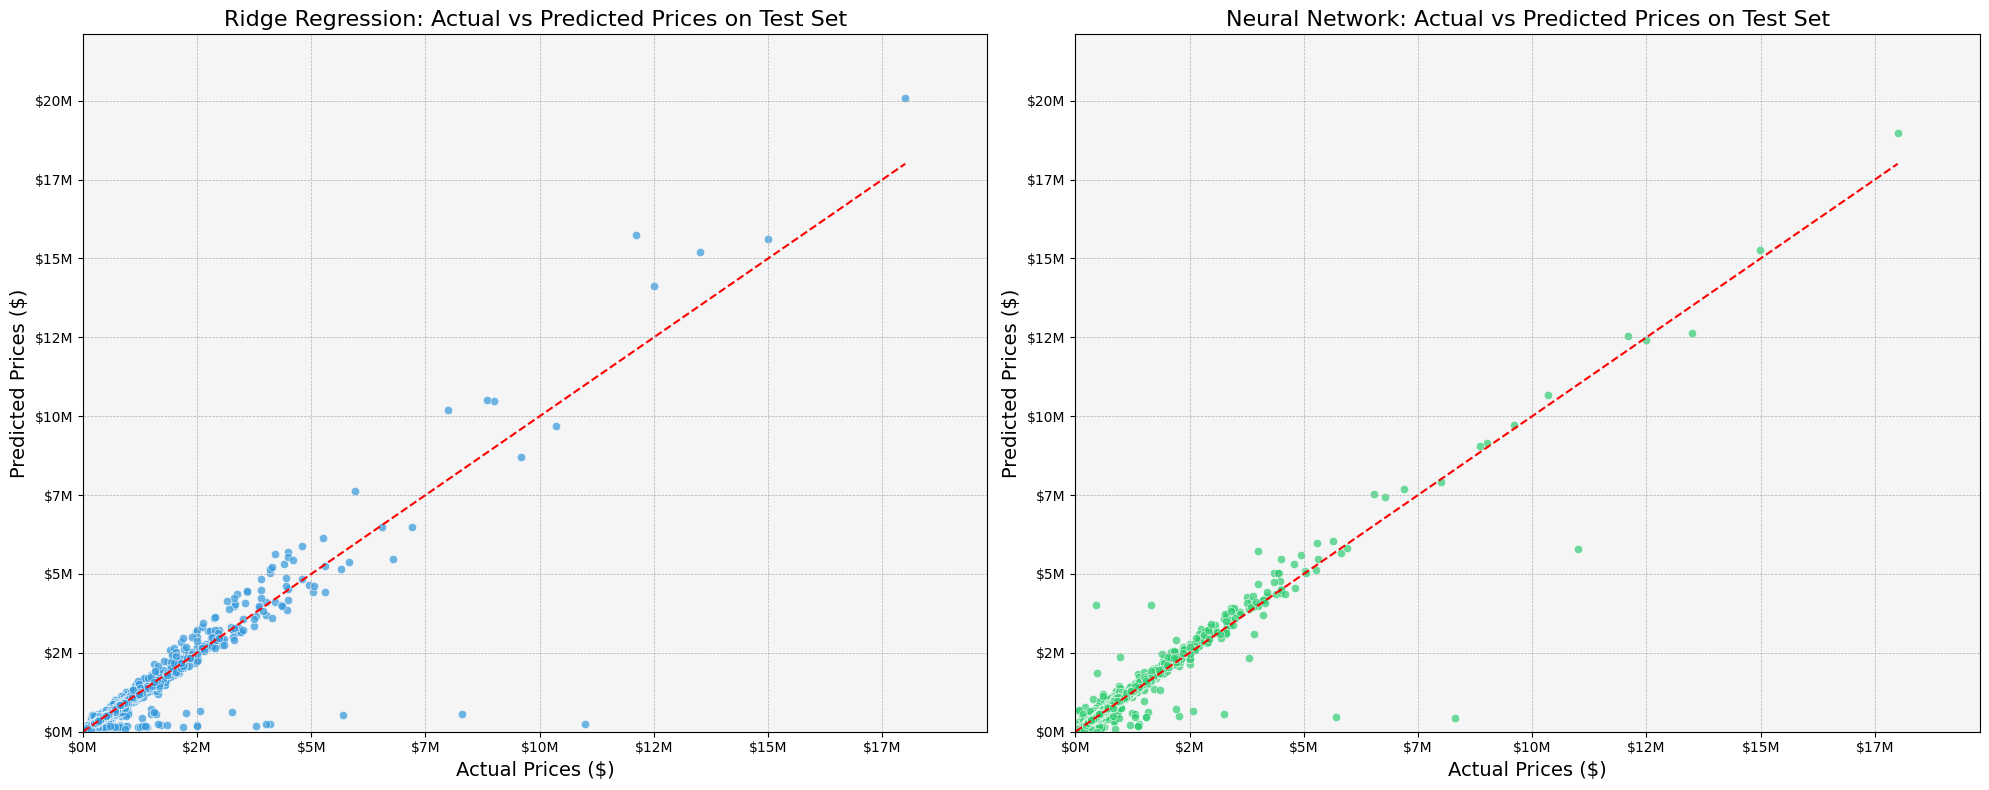

In [74]:
# Performance Metrics
#--------------------------

# Ridge Regression Metrics
print("Ridge Regression Metrics:")
#print(f"Validation MAE: ${ridge_mae_val:.2f}")
#print(f"Validation MSE: ${ridge_mse_val:.2f}")
print(f"Test MAE: ${ridge_mae_test:.2f}")
#print(f"Test MSE: ${ridge_mse_test:.2f}")

# Neural Network Metrics
print("Neural Network Metrics:")
#print(f"Validation MAE: ${nn_mae_val:.2f}")
#print(f"Validation MSE: ${nn_mse_val:.2f}")
print(f"Test MAE: ${nn_mae_test:.2f}")
#print(f"Test MSE: ${nn_mse_test:.2f}")


# Interpretability
#--------------------------
# Ridge Regression (Linear model) offers clear interpretability as you can directly see the effect of each feature on the output.
# Neural Networks, being a black-box model, doesn't offer the same level of interpretability. It's harder to understand how each feature affects the output.

# Training Time
#--------------------------
# time the training for both models
start_time = time.time()
ridge.fit(X_train, y_train)
ridge_time = time.time() - start_time

start_time = time.time()
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
nn_time = time.time() - start_time

print(f"Training time for Ridge Regression: {ridge_time:.2f} seconds")
print(f"Training time for Neural Network: {nn_time:.2f} seconds")
print("\n")


actual_prices_test = np.expm1(y_test)
#print(actual_prices_test[:5])
#print(y_ridge_pred_test[:5])
#print(y_nn_pred_test[:5])

# Predictions Visualization
#--------------------------
# custom formatter function
def millions_formatter(x, pos):
    return f'${int(x / 1e6)}M'

plt.figure(figsize=(20, 8))

# scatter plot for Ridge Regression predictions on Test Set
plt.subplot(1, 2, 1)
plt.scatter(actual_prices_test, y_ridge_pred_test, alpha=0.7, edgecolors='w', linewidth=0.5, color='#3498db')
plt.plot([min(actual_prices_test), max(actual_prices_test)], 
         [min(actual_prices_test), max(actual_prices_test)], color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Actual Prices ($)', fontsize=14)
plt.ylabel('Predicted Prices ($)', fontsize=14)
plt.title('Ridge Regression: Actual vs Predicted Prices on Test Set', fontsize=16)

# scatter plot for Neural Network predictions on Test Set
plt.subplot(1, 2, 2)
plt.scatter(actual_prices_test, y_nn_pred_test, alpha=0.7, edgecolors='w', linewidth=0.5, color='#2ecc71')
plt.plot([min(actual_prices_test), max(actual_prices_test)], 
         [min(actual_prices_test), max(actual_prices_test)], color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Actual Prices ($)', fontsize=14)
plt.ylabel('Predicted Prices ($)', fontsize=14)
plt.title('Neural Network: Actual vs Predicted Prices on Test Set', fontsize=16)

# axis limits in both plots
for ax in plt.gcf().axes:
    ax.set_xlim([0, max(actual_prices_test)*1.1])
    ax.set_ylim([0, max(max(y_ridge_pred_test), max(y_nn_pred_test))*1.1])
    # format
    formatter = FuncFormatter(millions_formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_facecolor('#f5f5f5')

plt.tight_layout()
plt.show()

##### 6. Conclusion and Future Work




##### Conclusion:

- **Historical Context**: Traditionally, predicting housing prices has been approached as a regression task due to the continuous nature of housing prices.
- **Performance Metrics**: Ridge Regression slightly outperformed the Neural Network on this dataset. This highlights that simpler models can sometimes capture patterns effectively, especially with limited data.
- **Interpretability**: Ridge Regression provides a clearer understanding of feature impact, making it more interpretable than the black-box nature of Neural Networks.
- **Training Time**: The significant training time difference, with Ridge Regression being much faster, can be a decisive factor, especially for rapid model deployment.
- **Model Error Context**: Considering the average and median house prices, the MAE values for both models indicate an error of approximately 7-8%.

##### Future Work:

1. **Feature Engineering**: Enhancing the dataset might boost model performance, especially for Neural Networks.
2. **Hyperparameter Tuning**: Both models can benefit from further hyperparameter tuning.
3. **Ensemble Techniques**: Combining predictions from both models might yield better results.
4. **Deep Dive into Neural Network**: Exploring varied architectures and techniques could refine Neural Network predictions.
5. **Addressing Data Collection Limitations**: Currently, the Redfin API has a limitation of 350 records per location. To achieve a decent sample size, a workaround was employed by merging data from various date subsets and dropping duplicates. Opening [an issue](https://github.com/ryansherby/RedfinScraper/issues/7) on the RedfinScraper GitHub repository suggests the need for an enhancement to address this limitation. Ideally, if Redfin increases this limit in the future, it would lead to more streamlined data collection and potentially richer datasets.

